# Visualizing latent space with t-SNE

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *

In [2]:
# %%capture
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',modality='t2')
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',modality='t2')
brats_train_loader, brats_test_loader, brats_val_loader = get_dataloader('brats',modality='t2')

  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

In [3]:
model_hcp = UNet3D(in_channels=1,
                    out_channels=1,
                    f_maps=[16, 32, 64, 128, 256],
                    layer_order='gcr',
                    num_groups=min(1, 8),
                    is_segmentation=False,
                    )
state_dict_ = torch.load('/media/hdd/viscent/SR-UNet/pretrained_models/unet_hcp_t2/1090.pth')['model']
state_dict = dict()
for k,v in state_dict_.items(): 
    k = k.replace('model.','')
    state_dict[k] = v
model_hcp.load_state_dict(state_dict)
model_hcp = model_hcp.cuda()


In [3]:
# %%capture 
model_dhcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_dhcp_t2/1600.pth')
model_hcp = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_hcp_t2/1090.pth')
model_brats = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_brats_t2/2730.pth')
model_dhcp = model_dhcp.cuda()
model_hcp = model_hcp.cuda()
model_brats = model_brats.cuda()
model_dhcp.eval()
model_hcp.eval()
model_brats.eval()
model = model_dhcp

In [4]:
# dHCP Model
latent_dhcp_dhcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_train.pt')
latent_hcp_dhcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_train.pt')
latent_dhcp_dhcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_val.pt')
latent_hcp_dhcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_val.pt')
latent_brown_dhcp = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brown_dhcp.pt')
# HCP Model
latent_dhcp_hcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_hcp_train.pt')
latent_hcp_hcp_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_hcp_train.pt')
latent_dhcp_hcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp_hcp_val.pt')
latent_hcp_hcp_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_hcp_hcp_val.pt')
latent_brown_hcp = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brown_hcp.pt')
# BraTS Model
latent_brats_brats_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_train.pt')
latent_brats_brats_val = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_val.pt')

In [ ]:
divergences_innate = np.zeros(3)
divergences_innate[0] = SamplesLoss("sinkhorn")(latent_brats_brats_val.flatten(start_dim=1), latent_brats_brats_train.flatten(start_dim=1))
divergences_innate[1] = SamplesLoss("sinkhorn")(latent_hcp_hcp_val.flatten(start_dim=1), latent_hcp_hcp_train.flatten(start_dim=1))
divergences_innate[2] = SamplesLoss("sinkhorn")(latent_dhcp_dhcp_val.flatten(start_dim=1), latent_dhcp_dhcp_train.flatten(start_dim=1))
latents = [latent_brats_brats_train,latent_hcp_hcp_train,latent_dhcp_dhcp_train]

# t-SNE

## dHCP-HCP

In [62]:
cursors = [0]
cursors.append(cursors[-1] + latent_dhcp_dhcp_train.shape[0])
cursors.append(cursors[-1] + latent_dhcp_dhcp_val.shape[0])
cursors.append(cursors[-1] + latent_hcp_dhcp_train.shape[0])
cursors.append(cursors[-1] + latent_hcp_dhcp_val.shape[0])
cursors.append(cursors[-1] + latent_brown_dhcp.shape[0])
labels = torch.zeros(cursors[-1])
labels[cursors[0]:cursors[1]] = 0
labels[cursors[1]:cursors[2]] = 1
labels[cursors[2]:cursors[3]] = 2
labels[cursors[3]:cursors[4]] = 3
labels[cursors[4]:cursors[5]] = 4

In [61]:
## t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("paper", font_scale=1.5,
                rc={"lines.linewidth": 2.5})    

# latent = torch.cat([latent_dhcp,latent_hcp,latent_brown],dim=0)
latent = torch.cat([latent_dhcp_dhcp_train,latent_dhcp_dhcp_val,latent_hcp_dhcp_train,latent_hcp_dhcp_val,latent_brown_dhcp],dim=0)
latent = latent.flatten(start_dim=1)
latent = latent.cpu().numpy()
tsne = TSNE(n_components=2)
latent_embedded = tsne.fit_transform(latent)

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



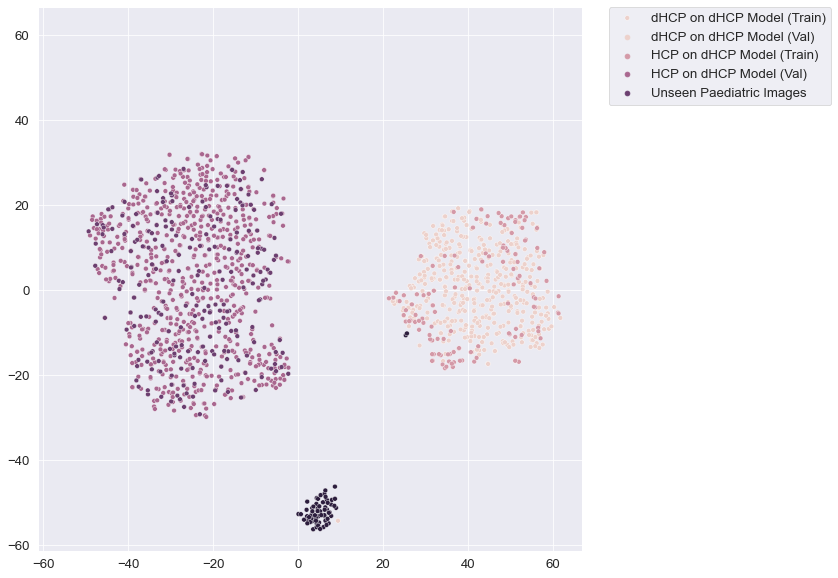

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=latent_embedded[:,0],y=latent_embedded[:,1],hue=labels,ax=ax)
lim = (latent_embedded.min()-5, latent_embedded.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(['dHCP on dHCP Model (Train)','dHCP on dHCP Model (Val)','HCP on dHCP Model (Train)','HCP on dHCP Model (Val)','Unseen Paediatric Images'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# fig.savefig('figures/tsne.svg',bbox_inches='tight')

In [66]:
for i in range(latent_embedded.shape[0]):
    if latent_embedded[i,0]>20:
        if labels[i] == 4:
            print(latent_embedded[i,0],latent_embedded[i,1])
            print(i-cursors[4])

25.326487 -10.582055
32
25.603716 -10.150241
54


# Generate Latents

In [52]:
images = []
image_tensors = []
t2_file_list = os.listdir('/media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/reg/')
t2_file_list = [os.path.join('/media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/reg/',f'%03d.nii.gz'%x) for x in range(len(t2_file_list))]
for t2_file in tqdm(t2_file_list,total=len(t2_file_list)):
    images.append(sitk.ReadImage(t2_file))
    subject = tio.Subject(t2=tio.ScalarImage(t2_file))
    transform_1 = tio.Compose([
        # tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.ToCanonical(),
        tio.transforms.Resample((1.,1.,1.)),
    ])
    subject = transform_1(subject)
    edge_max = max(subject.t2.data.shape)
    padding = ((edge_max - subject.t2.data.shape[1]) // 2, 
                (edge_max - subject.t2.data.shape[2]) // 2,
                    (edge_max - subject.t2.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.t2.data.unsqueeze(0).float()
    image_tensor = torch.transpose(image_tensor,4,2).flip([4,3,2])

    image_tensors.append(image_tensor)

  0%|          | 0/64 [00:00<?, ?it/s]

<Figure size 1440x720 with 0 Axes>

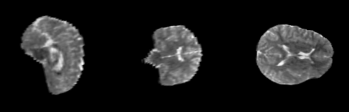

<Figure size 1440x720 with 0 Axes>

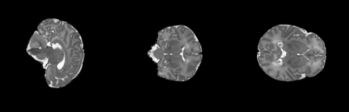

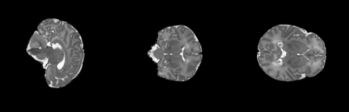

In [53]:
display_multiplanar_center(image_tensors[9][0,0])
display_multiplanar_center(iter(dhcp_train_loader).__next__()[1][0,0])

## dHCP Model

In [57]:
latent_dhcp = []
for img,gt in tqdm(dhcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_dhcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_train.pt')
latent_dhcp_dhcp_train = latent_dhcp
latent_hcp = []
for img,gt in tqdm(hcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_dhcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_train.pt')
latent_hcp_dhcp_train = latent_hcp
latent_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_dhcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_val.pt')
latent_dhcp_dhcp_val = latent_dhcp
latent_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_dhcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_val.pt')
latent_hcp_dhcp_val = latent_hcp
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model_dhcp,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'/media/hdd/viscent/SR-UNet/dev/latent_brown_dhcp.pt')
latent_brown_dhcp = latent_brown

  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/712 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

## HCP Model

In [ ]:
latent_dhcp = []
for img,gt in tqdm(dhcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_dhcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_train.pt')
latent_hcp = []
for img,gt in tqdm(hcp_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_dhcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_train.pt')
latent_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_dhcp.append(kl_forward_latent(model_dhcp,img))
latent_dhcp = torch.cat(latent_dhcp,dim=0)
torch.save(latent_dhcp,'/media/hdd/viscent/SR-UNet/dev/latent_dhcp_dhcp_val.pt')
latent_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_hcp.append(kl_forward_latent(model_dhcp,img))
latent_hcp = torch.cat(latent_hcp,dim=0)
torch.save(latent_hcp,'/media/hdd/viscent/SR-UNet/dev/latent_hcp_dhcp_val.pt')
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model_dhcp,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'/media/hdd/viscent/SR-UNet/dev/latent_brown_dhcp.pt')

## BraTS Model

In [48]:
latent_brats = []
for img,gt in tqdm(brats_train_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_brats,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_train.pt')
latent_brats = []
for img,gt in tqdm(brats_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_brats.append(kl_forward_latent(model_brats,img))
latent_brats = torch.cat(latent_brats,dim=0)
torch.save(latent_brats,'/media/hdd/viscent/SR-UNet/dev/latent_brats_brats_val.pt')


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

# Pick best Brown

<Figure size 1440x720 with 0 Axes>

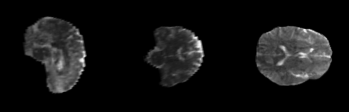

<Figure size 1440x720 with 0 Axes>

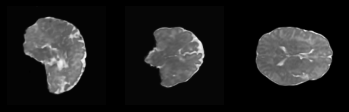

0


<Figure size 1440x720 with 0 Axes>

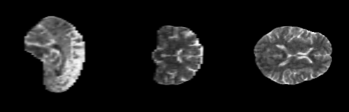

<Figure size 1440x720 with 0 Axes>

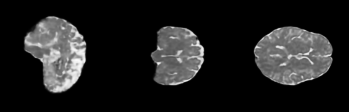

23


In [81]:
div_min = np.Inf
divs = []
for i, img in enumerate(image_tensors):
    if i==13:
        continue
    img = img.cuda()
    with torch.no_grad():
        latent = kl_forward_latent(model_dhcp,img).cuda()
        latent_ = latent_dhcp_dhcp_train.cuda()
        latent = latent.flatten().unsqueeze(0)
        latent_ = latent_.flatten(start_dim=1)
        div_cur = SamplesLoss("sinkhorn")(latent, latent_)
        divs.append(div_cur.cpu().numpy())
        if div_cur <= div_min:
            div_min = div_cur
            pred = model_dhcp(img)
            display_multiplanar_center(img[0,0].detach().cpu().numpy())
            display_multiplanar_center(pred[0,0].detach().cpu().numpy())
            im_array = img[0,0].detach().cpu().numpy()
            im_pred_array = pred[0,0].detach().cpu().numpy()
            # Normalize with lowest 1% and highest value
            im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
            im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
            im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
            im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
            im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
            im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
            im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
            im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
            im_sag.save('figures/outputs/Best_Brown/sag.png')
            im_cor.save('figures/outputs/Best_Brown/cor.png')
            im_ax.save('figures/outputs/Best_Brown/ax.png')
            im_pred_sag.save('figures/outputs/Best_Brown/pred_sag.png')
            im_pred_cor.save('figures/outputs/Best_Brown/pred_cor.png')
            im_pred_ax.save('figures/outputs/Best_Brown/pred_ax.png')
            print(i)

In [82]:
divs = np.array(divs)
div_args = np.argsort(divs)

In [87]:
div_args

array([22,  0,  9, 19, 26,  3, 48, 23,  2,  7, 12, 29, 14, 30,  1, 13, 21,
       33, 58, 11, 51, 41, 24,  8, 60,  6, 18, 57, 10, 16,  5, 42, 45, 52,
       50,  4, 20, 43, 61, 59, 54, 38, 28, 36, 62, 25, 44, 56, 53, 17, 55,
       46, 40, 34, 39, 47, 35, 15, 31, 49, 32, 37, 27])

<Figure size 1440x720 with 0 Axes>

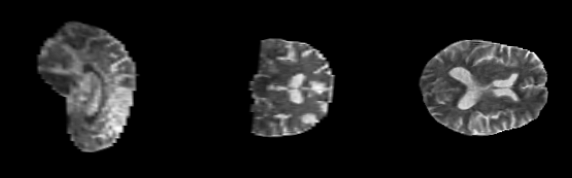

<Figure size 1440x720 with 0 Axes>

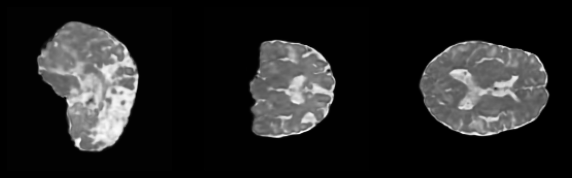

In [94]:
img = image_tensors[div_args[-1]].cuda()
print()
with torch.no_grad():
    pred = model_dhcp(img)
    display_multiplanar_center(img[0,0].detach().cpu().numpy())
    display_multiplanar_center(pred[0,0].detach().cpu().numpy())
    im_array = img[0,0].detach().cpu().numpy()
    im_pred_array = pred[0,0].detach().cpu().numpy()
    # Normalize with lowest 1% and highest value
    im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
    im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
    im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
    im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
    im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
    im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
    im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
    im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
    im_sag.save('figures/outputs/Best_Brown/sag.png')
    im_cor.save('figures/outputs/Best_Brown/cor.png')
    im_ax.save('figures/outputs/Best_Brown/ax.png')
    im_pred_sag.save('figures/outputs/Best_Brown/pred_sag.png')
    im_pred_cor.save('figures/outputs/Best_Brown/pred_cor.png')
    im_pred_ax.save('figures/outputs/Best_Brown/pred_ax.png')

# Schematic of Wasserstein

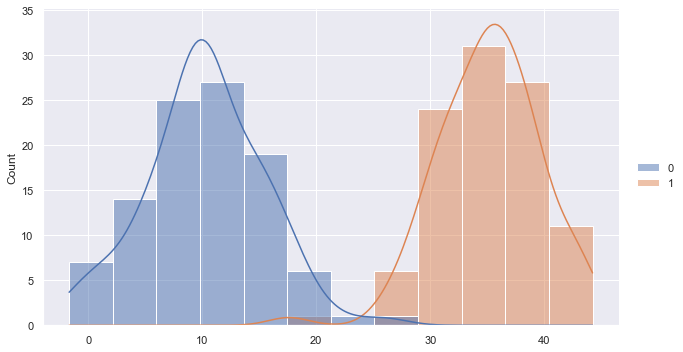

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
sns.plotting_context('talk')

x1 = np.random.normal(10, 5, 100)
x2 = np.random.normal(35, 5, 100)

x = np.stack((x1, x2), axis=1)

sns.displot(x, aspect=16/9, bins=12, kde=True)
plt.savefig('wasserstein_sched.svg',bbox_inches='tight')

# Quantitative Evaluation

In [6]:
from scipy.stats import ttest_ind
from scipy.stats import bartlett
import seaborn as sns

# Test on Validation dataset

In [9]:
models = [model_brats,model_hcp,model_dhcp]
model_picked_hcp = np.zeros(3)
divergences_hcp_per = np.zeros((len(hcp_val_loader),3))
model_correct_hcp = 0
idx = 0
for img,_ in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        _,divergences,model_idx = auto_inference(models, img, latents, divergences_innate,True)
        divergences_hcp_per[idx] += divergences
        idx += 1
        model_picked_hcp[model_idx] += 1
        if model_idx == 1:  model_correct_hcp += 1
idx=0
model_picked_dhcp = np.zeros(3)
divergences_dhcp_per = np.zeros((len(dhcp_val_loader),3))
model_correct_dhcp = 0
for img,_ in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        _,divergences,model_idx = auto_inference(models, img, latents, divergences_innate,True)
        model_picked_dhcp[model_idx] += 1
        divergences_dhcp_per[idx] += divergences
        idx += 1
        if model_idx == 2:  model_correct_dhcp += 1

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [12]:
np.savetxt('data/divergences_hcp_per.csv', divergences_hcp_per, delimiter=',')
np.savetxt('data/divergences_dhcp_per.csv', divergences_dhcp_per, delimiter=',')
np.savetxt('data/model_picked_hcp.csv', model_picked_hcp, delimiter=',')
np.savetxt('data/model_picked_dhcp.csv', model_picked_dhcp, delimiter=',')

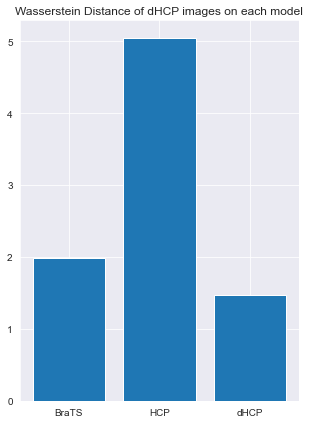

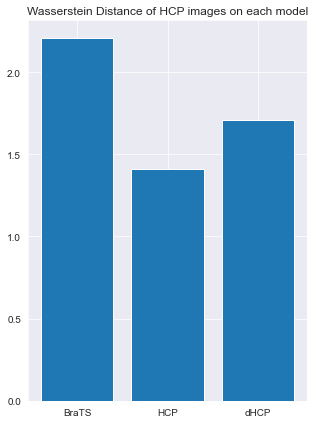

In [20]:
sns.set_style('darkgrid')
sns.plotting_context('paper')
plt.figure(figsize=(5,7))
plt.bar(['BraTS','HCP','dHCP'],divergences_dhcp_per.mean(axis=0))
plt.title('Wasserstein Distance of dHCP images on each model')
plt.savefig('figures/divergence_dhcp.svg',bbox_inches='tight')

sns.set_style('darkgrid')
sns.plotting_context('paper')
plt.figure(figsize=(5,7))
plt.bar(['BraTS','HCP','dHCP'],divergences_hcp_per.mean(axis=0))
plt.title('Wasserstein Distance of HCP images on each model')
plt.savefig('figures/divergence_hcp.svg',bbox_inches='tight')

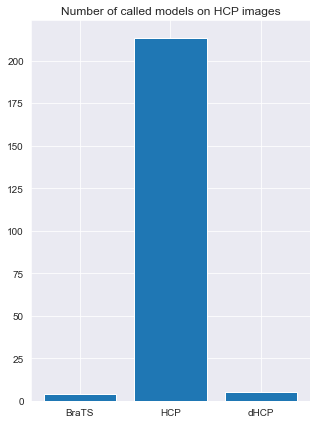

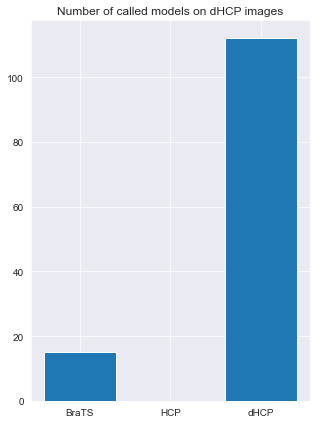

In [21]:
sns.set_style('darkgrid')
sns.plotting_context('paper')
plt.figure(figsize=(5,7))
plt.bar(['BraTS','HCP','dHCP'],model_picked_hcp)
plt.title('Number of called models on HCP images')
plt.savefig('figures/model_picked_hcp.svg',bbox_inches='tight')

sns.set_style('darkgrid')
sns.plotting_context('paper')
plt.figure(figsize=(5,7))
plt.bar(['BraTS','HCP','dHCP'],model_picked_dhcp)
plt.title('Number of called models on dHCP images')
plt.savefig('figures/model_picked_dhcp.svg',bbox_inches='tight')

## dHCP-dHCP

In [92]:
sinkhorn_dhcp_dhcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_dhcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_dhcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_dhcp_dhcp.append(loss.item())
sinkhorn_dhcp_dhcp = np.array(sinkhorn_dhcp_dhcp)

  0%|          | 0/10 [00:00<?, ?it/s]

## dHCP-HCP

In [28]:
sinkhorn_dhcp_hcp = []
for img,gt in tqdm(dhcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_hcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_hcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_dhcp_hcp.append(loss.item())
sinkhorn_dhcp_hcp = np.array(sinkhorn_dhcp_hcp)

  0%|          | 0/127 [00:00<?, ?it/s]

## HCP-HCP

In [33]:
sinkhorn_hcp_hcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_hcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_hcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_hcp_hcp.append(loss.item())
sinkhorn_hcp_hcp = np.array(sinkhorn_hcp_hcp)

  0%|          | 0/222 [00:00<?, ?it/s]

## HCP-dHCP

In [93]:
sinkhorn_hcp_dhcp = []
for img,gt in tqdm(hcp_val_loader):
    img = img.cuda()
    with torch.no_grad():
        latent_input = kl_forward_latent(model_dhcp,img)
        latent_input = latent_input.flatten().unsqueeze(0)
        latent_train = latent_dhcp.flatten(start_dim=1)
        loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
        sinkhorn_hcp_dhcp.append(loss.item())
sinkhorn_hcp_dhcp = np.array(sinkhorn_hcp_dhcp)

  0%|          | 0/10 [00:00<?, ?it/s]

## Visualization

p-value:  4.896488176156836e-07 *


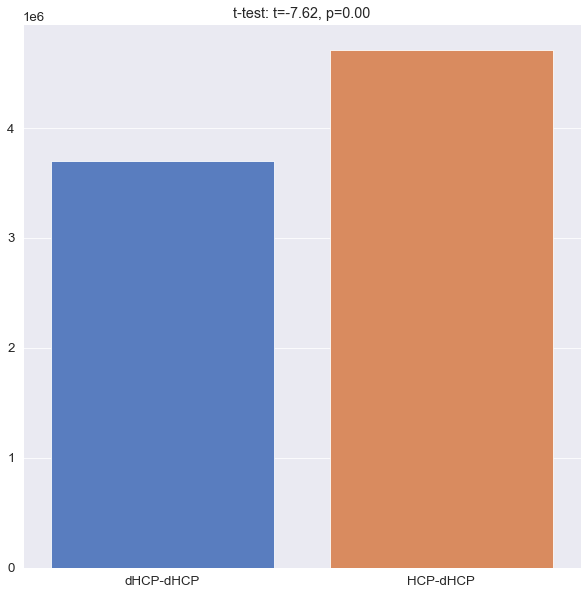

In [94]:
sns.barplot(x=['dHCP-dHCP','HCP-dHCP'],y=[sinkhorn_dhcp_dhcp.mean(),sinkhorn_hcp_dhcp.mean()])
ttest_dhcp_model = ttest_ind(sinkhorn_dhcp_dhcp,sinkhorn_hcp_dhcp)
plt.title('t-test: t=%.2f, p=%.2f'%(ttest_dhcp_model.statistic,ttest_dhcp_model.pvalue))
if ttest_dhcp_model.pvalue < 0.05:
    print('p-value: ',ttest_dhcp_model.pvalue,'*')
else:
    print('p-value: ',ttest_dhcp_model.pvalue)

p-value:  9.930080882775916e-36 *


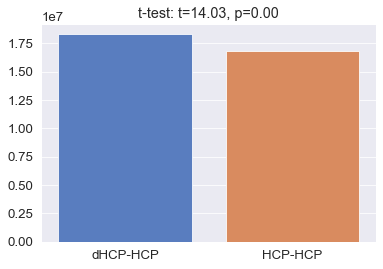

In [45]:
sns.barplot(x=['dHCP-HCP','HCP-HCP'],y=[sinkhorn_dhcp_hcp.mean(),sinkhorn_hcp_hcp.mean()])
ttest_hcp_model = ttest_ind(sinkhorn_dhcp_hcp,sinkhorn_hcp_hcp)
plt.title('t-test: t=%.2f, p=%.2f'%(ttest_hcp_model.statistic,ttest_hcp_model.pvalue))
if ttest_hcp_model.pvalue < 0.05:
    print('p-value: ',ttest_hcp_model.pvalue,'*')
else:
    print('p-value: ',ttest_hcp_model.pvalue)

# Inference Example

In [93]:
plt.rcParams['figure.figsize'] = [10, 10]

### dHCP Model

<Figure size 1440x720 with 0 Axes>

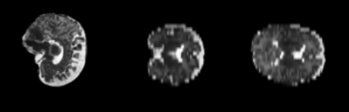

<Figure size 1440x720 with 0 Axes>

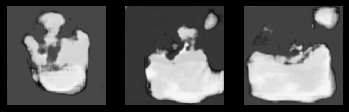

<Figure size 1440x720 with 0 Axes>

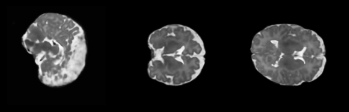

<Figure size 1440x720 with 0 Axes>

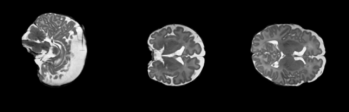

In [7]:
img,gt = iter(dhcp_val_loader).next()
img = img.cuda()
with torch.no_grad():
    pred = model_dhcp(img)
    pred_bad = model_hcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())
im_array = img[0,0].detach().cpu().numpy()
im_pred_array = pred[0,0].detach().cpu().numpy()
im_gt_array = gt[0,0].detach().cpu().numpy()
im_pred_bad_array = pred_bad[0,0].detach().cpu().numpy()
# Normalize with lowest 1% and highest value
im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
im_gt_array = (im_gt_array - np.percentile(im_gt_array,1))/(im_gt_array.max()-np.percentile(im_gt_array,1))
im_pred_bad_array = (im_pred_bad_array - np.percentile(im_pred_bad_array,1))/(im_pred_bad_array.max()-np.percentile(im_pred_bad_array,1))
im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
im_gt_sag = Image.fromarray(im_gt_array[im_gt_array.shape[0]//2,:,:]*255).convert('L')
im_gt_cor = Image.fromarray(im_gt_array[:,im_gt_array.shape[1]//2,:]*255).convert('L')
im_gt_ax = Image.fromarray(im_gt_array[:,:,im_gt_array.shape[2]//2]*255).convert('L')
im_pred_bad_sag = Image.fromarray(im_pred_bad_array[im_pred_bad_array.shape[0]//2,:,:]*255).convert('L')
im_pred_bad_cor = Image.fromarray(im_pred_bad_array[:,im_pred_bad_array.shape[1]//2,:]*255).convert('L')
im_pred_bad_ax = Image.fromarray(im_pred_bad_array[:,:,im_pred_bad_array.shape[2]//2]*255).convert('L')
im_sag.save('figures/outputs/dHCP_Model/sag.png')
im_cor.save('figures/outputs/dHCP_Model/cor.png')
im_ax.save('figures/outputs/dHCP_Model/ax.png')
im_pred_sag.save('figures/outputs/dHCP_Model/pred_sag.png')
im_pred_cor.save('figures/outputs/dHCP_Model/pred_cor.png')
im_pred_ax.save('figures/outputs/dHCP_Model/pred_ax.png')
im_gt_sag.save('figures/outputs/dHCP_Model/gt_sag.png')
im_gt_cor.save('figures/outputs/dHCP_Model/gt_cor.png')
im_gt_ax.save('figures/outputs/dHCP_Model/gt_ax.png')
im_pred_bad_sag.save('figures/outputs/dHCP_Model/pred_bad_sag.png')
im_pred_bad_cor.save('figures/outputs/dHCP_Model/pred_bad_cor.png')
im_pred_bad_ax.save('figures/outputs/dHCP_Model/pred_bad_ax.png')

### HCP Model

<Figure size 1440x720 with 0 Axes>

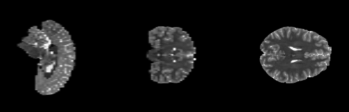

<Figure size 1440x720 with 0 Axes>

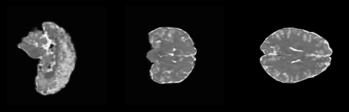

<Figure size 1440x720 with 0 Axes>

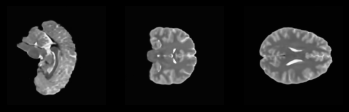

<Figure size 1440x720 with 0 Axes>

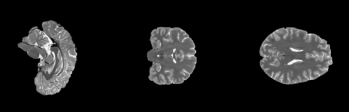

In [8]:
img,gt = iter(hcp_val_loader).next()
img = img.cuda()
with torch.no_grad():
    pred = model_hcp(img)
    pred_bad = model_dhcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())
im_pred_array = pred[0,0].detach().cpu().numpy()
im_gt_array = gt[0,0].detach().cpu().numpy()
im_pred_bad_array = pred_bad[0,0].detach().cpu().numpy()
# Normalize with lowest 1% and highest value
im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
im_gt_array = (im_gt_array - np.percentile(im_gt_array,1))/(im_gt_array.max()-np.percentile(im_gt_array,1))
im_pred_bad_array = (im_pred_bad_array - np.percentile(im_pred_bad_array,1))/(im_pred_bad_array.max()-np.percentile(im_pred_bad_array,1))
im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
im_gt_sag = Image.fromarray(im_gt_array[im_gt_array.shape[0]//2,:,:]*255).convert('L')
im_gt_cor = Image.fromarray(im_gt_array[:,im_gt_array.shape[1]//2,:]*255).convert('L')
im_gt_ax = Image.fromarray(im_gt_array[:,:,im_gt_array.shape[2]//2]*255).convert('L')
im_pred_bad_sag = Image.fromarray(im_pred_bad_array[im_pred_bad_array.shape[0]//2,:,:]*255).convert('L')
im_pred_bad_cor = Image.fromarray(im_pred_bad_array[:,im_pred_bad_array.shape[1]//2,:]*255).convert('L')
im_pred_bad_ax = Image.fromarray(im_pred_bad_array[:,:,im_pred_bad_array.shape[2]//2]*255).convert('L')
im_sag.save('figures/outputs/HCP_Model/sag.png')
im_cor.save('figures/outputs/HCP_Model/cor.png')
im_ax.save('figures/outputs/HCP_Model/ax.png')
im_pred_sag.save('figures/outputs/HCP_Model/pred_sag.png')
im_pred_cor.save('figures/outputs/HCP_Model/pred_cor.png')
im_pred_ax.save('figures/outputs/HCP_Model/pred_ax.png')
im_gt_sag.save('figures/outputs/HCP_Model/gt_sag.png')
im_gt_cor.save('figures/outputs/HCP_Model/gt_cor.png')
im_gt_ax.save('figures/outputs/HCP_Model/gt_ax.png')
im_pred_bad_sag.save('figures/outputs/HCP_Model/pred_bad_sag.png')
im_pred_bad_cor.save('figures/outputs/HCP_Model/pred_bad_cor.png')
im_pred_bad_ax.save('figures/outputs/HCP_Model/pred_bad_ax.png')


### BraTS Model

<Figure size 1440x720 with 0 Axes>

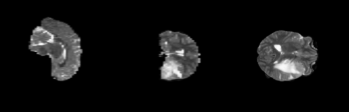

<Figure size 1440x720 with 0 Axes>

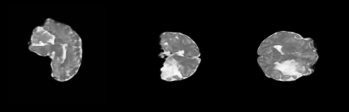

<Figure size 1440x720 with 0 Axes>

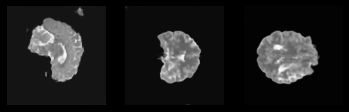

<Figure size 1440x720 with 0 Axes>

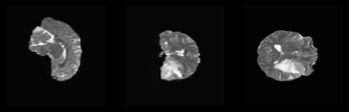

<Figure size 1440x720 with 0 Axes>

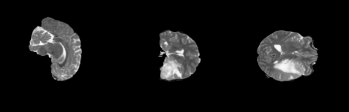

In [26]:
img,gt = iter(brats_test_loader).next()   
img = img.cuda()
with torch.no_grad():
    pred = model_brats(img)
    pred_bad = model_hcp(img)
    pred_worse = model_dhcp(img)
display_multiplanar_center(img[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_worse[0,0].detach().cpu().numpy())
display_multiplanar_center(pred_bad[0,0].detach().cpu().numpy())
display_multiplanar_center(pred[0,0].detach().cpu().numpy())
display_multiplanar_center(gt[0,0].detach().cpu().numpy())
im_array = img[0,0].detach().cpu().numpy()
im_pred_array = pred[0,0].detach().cpu().numpy()
im_gt_array = gt[0,0].detach().cpu().numpy()
im_pred_bad_array = pred_bad[0,0].detach().cpu().numpy()
im_pred_worse_array = pred_worse[0,0].detach().cpu().numpy()
# Normalize with lowest 1% and highest value
im_array = (im_array - np.percentile(im_array,1))/(im_array.max()-np.percentile(im_array,1))
im_pred_array = (im_pred_array - np.percentile(im_pred_array,1))/(im_pred_array.max()-np.percentile(im_pred_array,1))
im_gt_array = (im_gt_array - np.percentile(im_gt_array,1))/(im_gt_array.max()-np.percentile(im_gt_array,1))
im_pred_bad_array = (im_pred_bad_array - np.percentile(im_pred_bad_array,1))/(im_pred_bad_array.max()-np.percentile(im_pred_bad_array,1))
im_sag = Image.fromarray(im_array[im_array.shape[0]//2,:,:]*255).convert('L')
im_cor = Image.fromarray(im_array[:,im_array.shape[1]//2,:]*255).convert('L')
im_ax = Image.fromarray(im_array[:,:,im_array.shape[2]//2]*255).convert('L')
im_pred_sag = Image.fromarray(im_pred_array[im_pred_array.shape[0]//2,:,:]*255).convert('L')
im_pred_cor = Image.fromarray(im_pred_array[:,im_pred_array.shape[1]//2,:]*255).convert('L')
im_pred_ax = Image.fromarray(im_pred_array[:,:,im_pred_array.shape[2]//2]*255).convert('L')
im_gt_sag = Image.fromarray(im_gt_array[im_gt_array.shape[0]//2,:,:]*255).convert('L')
im_gt_cor = Image.fromarray(im_gt_array[:,im_gt_array.shape[1]//2,:]*255).convert('L')
im_gt_ax = Image.fromarray(im_gt_array[:,:,im_gt_array.shape[2]//2]*255).convert('L')
im_pred_bad_sag = Image.fromarray(im_pred_bad_array[im_pred_bad_array.shape[0]//2,:,:]*255).convert('L')
im_pred_bad_cor = Image.fromarray(im_pred_bad_array[:,im_pred_bad_array.shape[1]//2,:]*255).convert('L')
im_pred_bad_ax = Image.fromarray(im_pred_bad_array[:,:,im_pred_bad_array.shape[2]//2]*255).convert('L')
im_pred_worse_sag = Image.fromarray(im_pred_worse_array[im_pred_worse_array.shape[0]//2,:,:]*255).convert('L')
im_pred_worse_cor = Image.fromarray(im_pred_worse_array[:,im_pred_worse_array.shape[1]//2,:]*255).convert('L')
im_pred_worse_ax = Image.fromarray(im_pred_worse_array[:,:,im_pred_worse_array.shape[2]//2]*255).convert('L')
im_sag.save('figures/outputs/BraTS_Model/sag.png')
im_cor.save('figures/outputs/BraTS_Model/cor.png')
im_ax.save('figures/outputs/BraTS_Model/ax.png')
im_pred_sag.save('figures/outputs/BraTS_Model/pred_sag.png')
im_pred_cor.save('figures/outputs/BraTS_Model/pred_cor.png')
im_pred_ax.save('figures/outputs/BraTS_Model/pred_ax.png')
im_gt_sag.save('figures/outputs/BraTS_Model/gt_sag.png')
im_gt_cor.save('figures/outputs/BraTS_Model/gt_cor.png')
im_gt_ax.save('figures/outputs/BraTS_Model/gt_ax.png')
im_pred_bad_sag.save('figures/outputs/BraTS_Model/pred_bad_sag.png')
im_pred_bad_cor.save('figures/outputs/BraTS_Model/pred_bad_cor.png')
im_pred_bad_ax.save('figures/outputs/BraTS_Model/pred_bad_ax.png')
im_pred_worse_sag.save('figures/outputs/BraTS_Model/pred_worse_sag.png')
im_pred_worse_cor.save('figures/outputs/BraTS_Model/pred_worse_cor.png')
im_pred_worse_ax.save('figures/outputs/BraTS_Model/pred_worse_ax.png')

# Degraded/SR BraTS preparation

In [59]:
data_dir = '/media/hdd/BraTS2020_lores'
list_dir = glob.glob(op.join(data_dir, '*'))
list_dir.sort()
list_basenames_ = [op.basename(x) for x in list_dir]
list_basenames = [x for x in list_basenames_ if x.endswith('_t2.nii.gz')]
list_images = [op.join(data_dir,x,x+'_t2.nii.gz') for x in list_basenames]
num_samples = len(list_dir)
spacing = [1.5,1.5,5.0]
spacing = np.array(spacing)


In [57]:
for img in list_images:
    subject = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    subject_original = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    spacing_ = subject.image_t1.spacing
    size_ = subject.image_t1.data.shape[1:]
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.Resample(spacing),
        tio.transforms.Resample((1.,1.,1.)),
        tio.transforms.RandomGamma((0.2,0.2))
    ])
    subject = transform_1(subject)
    edge_max = max(subject.image_t1.data.shape)
    padding = ((edge_max - subject.image_t1.data.shape[1]) // 2, 
                (edge_max - subject.image_t1.data.shape[2]) // 2,
                    (edge_max - subject.image_t1.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)

    transform_inv = tio.Compose([
        tio.transforms.Resample(spacing_),
        tio.transforms.CropOrPad(size_),
    ])
    subject = transform_inv(subject)
    # save
    subject.image_t1.save(img)

FileNotFoundError: File not found: "/media/hdd/BraTS2020_lores/name_mapping.csv/name_mapping.csv_t2.nii.gz"

In [15]:
data_dir = '/media/hdd/BraTS2020_SR'
list_dir = glob.glob(op.join(data_dir, '*'))
list_dir.sort()
list_basenames_ = [op.basename(x) for x in list_dir]
list_basenames = [x for x in list_basenames_ if x.startswith('BraTS20_Training_')]
list_images = [op.join(data_dir,x,x+'_t2.nii.gz') for x in list_basenames]
num_samples = len(list_dir)
spacing = [1.5,1.5,5.0]
spacing = np.array(spacing)

In [18]:
list_images

['/media/hdd/BraTS2020_SR/BraTS20_Training_001/BraTS20_Training_001_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_002/BraTS20_Training_002_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_003/BraTS20_Training_003_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_004/BraTS20_Training_004_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_005/BraTS20_Training_005_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_006/BraTS20_Training_006_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_007/BraTS20_Training_007_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_008/BraTS20_Training_008_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_009/BraTS20_Training_009_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_010/BraTS20_Training_010_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_011/BraTS20_Training_011_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Training_012/BraTS20_Training_012_t2.nii.gz',
 '/media/hdd/BraTS2020_SR/BraTS20_Traini

In [22]:
for img in tqdm(list_images):
    subject = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    subject_original = tio.Subject(
        image_t1 = tio.ScalarImage(img),
    )
    spacing_ = subject.image_t1.spacing
    size_ = subject.image_t1.data.shape[1:]
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.Resample(spacing),
        tio.transforms.Resample((1.,1.,1.)),
        tio.transforms.RandomGamma((0.2,0.2))
    ])
    subject = transform_1(subject)
    edge_max = max(subject.image_t1.data.shape)
    padding = ((edge_max - subject.image_t1.data.shape[1]) // 2, 
                (edge_max - subject.image_t1.data.shape[2]) // 2,
                    (edge_max - subject.image_t1.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.image_t1.data.unsqueeze(0).cuda()
    subject.image_t1.set_data(model_brats(image_tensor).squeeze(0).cpu().detach().numpy())
    transform_inv = tio.Compose([
        tio.transforms.Resample(spacing_),
        tio.transforms.CropOrPad(size_),
    ])
    subject = transform_inv(subject)
    # save
    subject.image_t1.save(img)

  0%|          | 0/210 [00:00<?, ?it/s]

FileNotFoundError: File not found: "/media/hdd/BraTS2020_SR/BraTS20_Training_210/BraTS20_Training_210_t2.nii.gz"

torch.Size([1, 240, 240, 155])
torch.Size([1, 240, 240, 155])


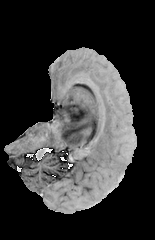

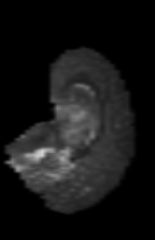

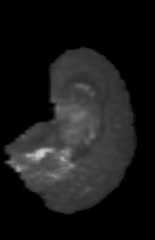

In [55]:
# overlay two images
im_array = subject.image_t1.data
im_original_array = subject_original.image_t1.data
print(im_array.shape)
print(im_original_array.shape)
im_array = im_array[0,:,:,:]
im_original_array = im_original_array[0,:,:,:]
im_array = im_array[im_array.shape[0]//2,:,:]
im_original_array = im_original_array[im_original_array.shape[0]//2,:,:]
im_array = im_array*255
im_original_array = im_original_array*255
im_array = im_array.numpy().astype(np.uint8)
im_original_array = im_original_array.numpy().astype(np.uint8)
im = Image.fromarray(im_array).convert('L')
im_original = Image.fromarray(im_original_array).convert('L')
im_blended = Image.blend(im, im_original, alpha=0.1)
display(im_original)
display(im)
display(im_blended)

# Model Selector